In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model_name):
    model = model_from_json(open(model_name + 'model.json').read())
    model.load_weights(model_name + 'weights.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model_name, eps):
    p = np.sign(generate_grads(x, label, model_name))
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
eps = 0.3
border = 0.4

In [6]:
max_n = 100

In [7]:
num_classes = 10

In [8]:
model_name = 'mnist_mlp_'

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_test  = X_test.reshape(10000, 784).astype('float32') / 255
print(X_test.shape[0], 'test samples')

y_test_catego = keras.utils.to_categorical(y_test, num_classes)
print(y_test_catego.shape)

10000 test samples
(10000, 10)


In [10]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [11]:
adv_test = generate_adv_list(X_test[:max_n], y_test[:max_n], model_name, eps)
adv_test.shape

W0113 16:14:26.732147 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0113 16:14:26.754264 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0113 16:14:26.772729 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0113 16:14:26.773784 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehol

0


W0113 16:14:26.945968 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0113 16:14:27.031941 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(100, 784)

In [12]:
def change_to_nichi_list(x_list, border):
    return np.where(x_list < border, 0, 1)

In [13]:
nichi_test = change_to_nichi_list(adv_test, border)

In [14]:
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
None


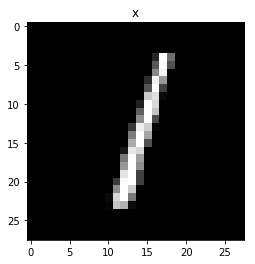

In [15]:
idx = 2
x = X_test[idx]
y = y_test[idx]

plt.imshow(x.reshape(28,28), 'gray')
plt.title('x')
plt.show()

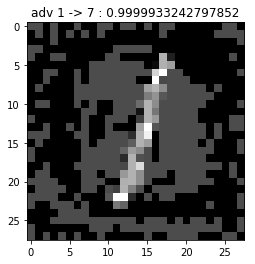

In [16]:
adv = adv_test[idx]

pred_class, pred_per = predict(adv, model)
plt.imshow(adv.reshape(28,28), 'gray')
plt.title(f'adv {y} -> {pred_class} : {pred_per}')
plt.show()

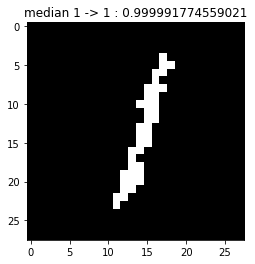

In [17]:
nichi = np.where(adv < border, 0, 1)

pred_class, pred_per = predict(nichi, model)
plt.imshow(nichi.reshape(28,28), 'gray')
plt.title(f'median {y} -> {pred_class} : {pred_per}')
plt.show()

In [18]:
score = model.evaluate(X_test, y_test_catego, verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

X_test
Test loss : 0.10931812194355357
Test accuracy : 0.9842


In [19]:
score = model.evaluate(X_test[:max_n], y_test_catego[:max_n], verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

X_test
Test loss : 4.2783838143805045e-05
Test accuracy : 1.0


In [20]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('adv_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv_test
Test loss : 15.22770034790039
Test accuracy : 0.0


In [21]:
score = model.evaluate(nichi_test, y_test_catego[:max_n], verbose=0)
print('nichi_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

nichi_test
Test loss : 2.281194443702698
Test accuracy : 0.74
